In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from tqdm import tqdm_notebook
import cvxpy as cp

# Utils

In [6]:
def best_arm_rnd(my_list):
    """
    returns the index i for which list[i] = max
    breaks ties at random
    """
    my_list = np.array(my_list)
    max_val = np.max(my_list)
    all_max = np.argwhere(my_list == max_val).flatten()
    return np.random.choice(all_max)


# Algorithms

In [7]:
class Algorithm:
    def __init__(self,
                nb_arms,
                horizon,
                noise_variance,
                ):
        """
        noise_variance: noise of reward
        """
        self.horizon = horizon
        self.nb_arms = nb_arms
        
        self.noise_variance = noise_variance
        self.noise_std = np.sqrt(noise_variance)
        

    
    def run_algo(self):
        raise NotImplementedError
        
    def run(self, NbExps, plot=True):
        """
        Run algo for NbExps experiments 
        """
        self.all_cumregrets = np.zeros((NbExps, self.horizon))
        for exp in (range(NbExps)):
            self.run_algo()
            cum_regret = np.cumsum(self.regret)
            self.all_cumregrets[exp,:] = cum_regret

        lower_regrets = np.percentile(self.all_cumregrets, 10, axis=0)
        upper_regrets = np.percentile(self.all_cumregrets, 90, axis=0)
        if plot:
            plt.fill_between(np.arange(self.horizon), lower_regrets,upper_regrets,alpha=0.2)
            plt.plot(np.mean(self.all_cumregrets,axis=0))
            plt.title(self.name)
            plt.grid()
        return np.mean(self.all_cumregrets,axis=0), lower_regrets, upper_regrets

# Optimal allocation matching

In [21]:
class haoLinearContextualBandit(Algorithm):
    def __init__(self,
                 action_sets,
                 noise_variance=0.25,
                 horizon=10000,
                 theta_given=None,
                 action_set_proba=None
                 ):
        
        self.action_sets = action_sets # (M,K,d)
        self.M = self.action_sets.shape[0]
        
        super().__init__(nb_arms=self.action_sets.shape[1],
                         horizon=horizon, 
                         noise_variance=noise_variance,
                         )
        self.d=self.action_sets.shape[2]

        self.theta_given = theta_given #(d,1)       
        
        self.name = f"Hao_K-{self.nb_arms}_d-{self.d}_T-{horizon}_std-{self.noise_std}"
        
        self.crit_opt = 1.1 # whenever det(G_t) increases by crit_opt, recompute opt (Not implemented)
        
        self.action_set_proba = action_set_proba #if specified, list of probabilities for each context
        
        self.fn = self.f_n_d(delta=self.horizon)
        
        
    def init_theta(self):
        """
        Initialize theta and true mus
        """
        if self.theta_given is None:
            self.theta = np.random.normal(0,1,(self.nb_arms, 1, self.d,))
        else:
            self.theta = self.theta_given
            assert self.theta_given.shape == self.theta_hat.shape
        self.true_mus = self.action_sets.dot(self.theta).reshape(self.M, self.nb_arms) 
        
    
    def f_n_d(self,delta,c=1):
        """
        Compute f_{n,\delta} 
        """
        n = self.horizon
        fnd = (2*(1+1/np.log(n))*np.log(1/delta)\
               + c*self.d*np.log(self.d*np.log(n)))
        return fnd
   

    def reset_algo(self):
        self.Delta_hat = np.zeros((self.M, self.nb_arms))
        self.theta_hat = np.zeros((self.d, 1))
        self.mu_hat = np.zeros((self.nb_arms,))
        
        self.explo_count = 0
        
        self.regret = np.zeros((self.horizon,)) # Regret history
        self.reward = np.zeros((self.horizon,)) # Rewards history
        
        self.nb_times_drawn = np.zeros((self.M, self.nb_arms), dtype=np.int16) 

        self.cov_G = np.zeros((self.d, self.d))
        self.sum_XY = np.zeros((self.d,1))
        
        self.init_theta()
        
        self.max_repeat_T = 0 # Incremented when optimization returns None (should not be too high)         
        self.diff_theta = np.zeros((self.horizon,))
      
        
    def sample_action_set(self,):
        """
        sample according to self.action_set_proba 
        Return:
        action context A_ct : (K,d)
        context = idx of context (\in self.M)
        """
        assert len(self.action_set_proba) == self.M
        assert sum(self.action_set_proba) == 1
        
        rnd = np.random.uniform(low=0, high=1)
        probabilities = [0] + self.action_set_proba
        cur_sum = 0
        for m in range(self.M):
            if cur_sum  <= rnd <= cur_sum + probabilities[m+1]:
                context = m
                break
            cur_sum = cur_sum + probabilities[m+1]
   
        return self.action_sets[context], context

  
                               
  
        
    
    
    def compute_optimization(self):
        """
        Solve the approximated allocation rule
        min \sum_m \sum_x T_x^m \hat{delta}_x^m
        st 
        T_x^m >= 0
        x^T {H_T^-1}^2 x <= (\hat{delta}_x^m^2 / f_n) for all x
        H_T = \sum_m \sum_x T_x^m  xx^T
        """
        deltas = self.Delta_hat.flatten() # (M*K,)
        T = cp.Variable(self.M * self.nb_arms) # (M*K,)
        H_T = cp.Variable((self.d, self.d))
        
        
        all_arms = self.action_sets.reshape(self.M*self.nb_arms,
                                            self.d)
        dfn = np.square(deltas)/self.fn
        #print(f". dfn {dfn}")
        idx_non_zeros = np.where(dfn > 0)[0]
        
        #print(f". all arms non zeros \n {[all_arms[k] for k in idx_non_zeros]}")
        
        objective = cp.Minimize(T @ deltas)
        eps = 0.1
        constraints = [T >= eps] + \
                      [H_T == all_arms.T @ cp.diag(T) @ all_arms ] + \
                      [cp.matrix_frac(all_arms[k], H_T) <= dfn[k] for k in idx_non_zeros] 
                      
        problem = cp.Problem(objective, constraints)
        opt_val = problem.solve()
        
        
        T = T.value
        H_T = H_T.value
        
       # print(f". T opt : {T}")
       # print(f". H_T opt: {H_T}")
       # assert np.linalg.matrix_rank(H_T) == self.d, H_T
       # assert (T >= -0.1).all(), T
       
        #T[T<=0] = eps
        if T is not None:
            self.T = T.reshape(self.M, self.nb_arms)
        else:
            self.max_repeat_T += 1
        return H_T
        
  
    
    def choose_LinUCB(self, A_ct, context):
        """
        LinUCB policy
        """
        bonus = np.sqrt(self.f_n_d(delta=1/self.explo_count**2))*self.norm_x_G_inv(A_ct=A_ct)
        return best_arm_rnd(self.mu_hat[context] + bonus)
    
    
    def compute_b1_b2(self, context):
        """
        Returns indices of arm b1, b2 when doing exploration
        """
        tmp_b1 = (self.nb_times_drawn[context]\
                  /np.min([self.T[context],
                           self.fn/self.Delta_hat_min**2*np.ones(self.nb_arms)], axis=0))
        b1 = np.argmin(tmp_b1)
        b2 = np.argmin(self.nb_times_drawn[context])
        return b1, b2
        
                
                  
                  
        
    def explore(self, A_ct, context):
        """
        Returns index of arm chosen when doing exploration
        """
        self.explo_count += 1
        
        cond = np.min([self.T[context],
                      (self.fn/self.Delta_hat_min**2)*np.ones((self.nb_arms,))], axis=0)
        
        if (self.nb_times_drawn[context] >= cond).all():
            return self.choose_LinUCB(A_ct=A_ct, context=context)
        else:
            b1, b2 = self.compute_b1_b2(context=context)
            if self.nb_times_drawn[context][b2] <= self.explo_param*(self.explo_count-1):
                return b2
            else:
                return b1
        
    
    def norm_x_G_inv(self,  A_ct, idx_arm=None):
        """
        Compute ||x||_{G^-1}^2 if the index of a single arm is specified (returns float)
        Otherwise returns a (K,) array where each entry k is ||x_k||_{G^-1}^2
        A_ct: (K,d)
        """
        inv_cov_G = np.linalg.inv(self.cov_G)
        if A_ct is None and arm is not None:
            arm = A_ct[idx_arm].reshape(self.d,1)
            return float(arm.dot(inv_cov_G).dot(arm.T))
        elif A_ct is not None:
            return np.diag(A_ct.dot(inv_cov_G).dot(A_ct.T))
        else:
            raise ValueError
    
    def should_exploit(self, A_ct, context):
        """
        Return true if for all x in A_ct,
        ||x||_{G_{t-1}^-1}^2 <= max(delta_min/fn, delta_x/fn)
        """
        x_G_inv = self.norm_x_G_inv(A_ct=A_ct) #(K,)
       
        inv_cov_G = np.linalg.inv(self.cov_G)
        
        assert x_G_inv.shape[0] == self.nb_arms
        cond = np.max([(self.Delta_hat_min**2/self.fn) * np.ones((self.nb_arms,)),
                       np.square(self.Delta_hat[context])/self.fn], axis=0)
        if (x_G_inv <= cond).all():
            return True
        else:
            #print(x_G_inv)
            #print(f"cond = {cond} \n")
            return False
            
    def update_stats(self, t, A_ct, context, idx_arm, init_phase=False):
        self.nb_times_drawn[context, idx_arm] += 1
        arm = A_ct[idx_arm].reshape(self.d,1)
        
        true_mus_ct = self.true_mus[context]# A_ct.dot(self.theta)
        
        reward_noise = np.random.normal(0,self.noise_std)
        self.reward[t] = true_mus_ct[idx_arm] + reward_noise
        self.regret[t] = np.max(true_mus_ct) - true_mus_ct[idx_arm]        
        self.cov_G = self.cov_G + arm.dot(arm.T)
        self.sum_XY = self.sum_XY + self.reward[t]*arm
        
        # Not necessary for algorithm:
        self.diff_theta[t] = np.sum(np.abs(self.theta-self.theta_hat))
        
        
        
        
        if t >= self.d - 1:
            assert np.linalg.matrix_rank(self.cov_G) == self.d, np.linalg.matrix_rank(self.cov_G)
            
            self.explo_param = 1/np.log(np.log(t+1))
            
            self.theta_hat = np.linalg.inv(self.cov_G).dot(self.sum_XY)
            
            self.mu_hat = self.action_sets.dot(self.theta_hat).reshape(self.M, self.nb_arms) 
            mu_opt = np.max(self.mu_hat, axis=1).reshape(self.M,1)
            
            self.Delta_hat = mu_opt - self.mu_hat
           
            self.Delta_hat_min = np.min(self.Delta_hat[self.Delta_hat>0])
            
            
    def init_phase(self,):
        """
        return arm which is not in the span of arms already drawn
        """
        past_arms = np.zeros((self.d,self.d))
        for t in range(self.d):
            A_ct, context = self.sample_action_set()
            potentials = []
            for k in range(self.nb_arms):
                past_arms[t] = A_ct[k]
                if np.linalg.matrix_rank(past_arms) == t+1:
                    potentials.append(k)
           
            assert len(potentials) >= 1, past_arms
            idx_arm = np.random.choice(potentials)
            past_arms[t] = A_ct[idx_arm]
            self.update_stats(t=t,
                              A_ct=A_ct, 
                              context=context, 
                              idx_arm=idx_arm,
                             init_phase=True)
        
    def run_algo(self):
        self.reset_algo()
        self.init_phase()

        for t in range(self.d, self.horizon):
            if t %(self.horizon//5)==0:
                print(f"*********  t = {t}, Nb of times solver failed: {self.max_repeat_T}")
            A_ct, context = self.sample_action_set()
            self.compute_optimization()
           # assert (self.T>=0).all(), self.T

  
            if self.should_exploit(A_ct=A_ct, context=context):
                idx_arm = best_arm_rnd(self.mu_hat[context])
            else:
                idx_arm = self.explore(A_ct=A_ct, context=context)



            self.update_stats(t=t, A_ct=A_ct, context=context, idx_arm=idx_arm)





### Fixed action set

In [18]:
# Fixed 
u=0.2
action_sets = np.array([[[1,0],
                       [0,1],
                       [1-u,5*u]]])
probabilities = [1]
theta = np.array([[1],
                 [0],])

In [19]:
N = 10000
noise_variance = 1
test_hao = haoLinearContextualBandit(action_sets= action_sets,
                                     noise_variance=noise_variance,
                                     horizon=N,
                                     theta_given=theta,
                                     action_set_proba=probabilities
           )

*********  t = 2000, max_repeat 0
*********  t = 4000, max_repeat 0
*********  t = 6000, max_repeat 0
*********  t = 8000, max_repeat 0


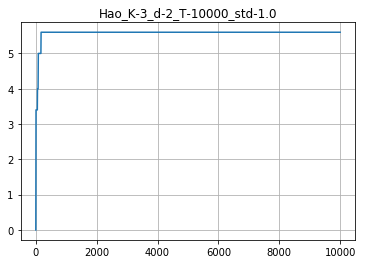

In [20]:
regrets = test_hao.run(NbExps=1, plot=True)

## Changing action set

In [22]:
# Changing action set
A_1 = np.array([[1,0,0],
               [0,1,0],
               [0,0.5,0.9]])

# Rows correspond to arms

A_2 = np.array([[0,1,0],
               [0,0,1],
               [0.9,0.5,0]])

action_sets = np.array([A_1,A_2]) # (M, K, d)
probabilities = [0.3, 0.7]

theta = np.array([[1],
                 [0],
                 [1]])
true_mus = action_sets.dot(theta)
print(true_mus)

[[[1. ]
  [0. ]
  [0.9]]

 [[0. ]
  [1. ]
  [0.9]]]


In [23]:
N = 10000
noise_variance = 1
test_hao = haoLinearContextualBandit(action_sets= action_sets,
                                     noise_variance=noise_variance,
                                     horizon=N,
                                     theta_given=theta,
                                     action_set_proba=probabilities
                                    )

In [ ]:
test_hao.run(NbExps=1)

*********  t = 2000, Nb of times solver failed: 0
*********  t = 4000, Nb of times solver failed: 0
*********  t = 6000, Nb of times solver failed: 0


In [859]:
# Changing action set scenario 2
A_1 = np.array([[1,0],
               [0,1],
               [0.9,0.5]])

# Rows correspond to arms

A_2 = np.array([[0,1],
               [-1,0],
               [-1,0]])

action_sets = np.array([A_1,A_2]) # (M, K, d)
probabilities = [0.99, 0.01]

theta = np.array([[1],
                 [0]])
true_mus = action_sets.dot(theta)
print(true_mus)

[[[ 1. ]
  [ 0. ]
  [ 0.9]]

 [[ 0. ]
  [-1. ]
  [-1. ]]]


*********  t = 2000, max_repeat 180
*********  t = 4000, max_repeat 449
*********  t = 6000, max_repeat 737
*********  t = 8000, max_repeat 1037


(array([1.00e-01, 1.00e-01, 1.10e+00, ..., 1.67e+03, 1.67e+03, 1.67e+03]),
 array([1.00e-01, 1.00e-01, 1.10e+00, ..., 1.67e+03, 1.67e+03, 1.67e+03]),
 array([1.00e-01, 1.00e-01, 1.10e+00, ..., 1.67e+03, 1.67e+03, 1.67e+03]))

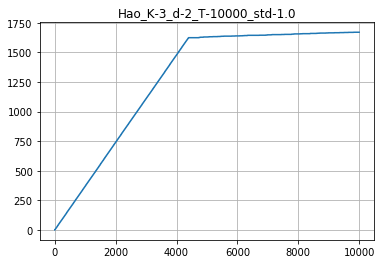

In [860]:
N = 10000
noise_variance = 1
test_hao = haoLinearContextualBandit(action_sets= action_sets,
                                     noise_variance=noise_variance,
                                     horizon=N,
                                     theta_given=theta,
                                     action_set_proba=probabilities
                                    )
test_hao.run(NbExps=1)